In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import os
import os.path as osp
from tqdm import tqdm
import shutil 
import sys
import argparse
import pickle
from collections import OrderedDict

from utils import *
from models import *

import matplotlib.pyplot as plt

## load model & data

In [2]:
torch.cuda.is_available()

True

In [3]:
#name = 'SIRv4_int_11_hyperdeepoent_rec'
#name = 'SIRv4_int_11_hyperdeepoent'

name = 'SIRv5_int_11_hyperdeepoent_rec'

In [4]:
def select_model(model_name):
    if model_name=='deeponet':
        return deeponet
    elif model_name=='shiftdeeponet':
        return shiftdeeponet
    elif model_name=='flexdeeponet':
        return flexdeeponet
    elif model_name=='NOMAD':
        return NOMAD
    elif model_name=='hyperdeeponet':
        return hyperdeeponet

def load_model(model, state_dict):
    if args.multgpu:
        new_keys = []
        for key in state_dict.keys():
            new_key = key[7:]    # remove the 'module.'
            new_keys.append(new_key)
        new_values = OrderedDict(list(zip(new_keys, state_dict.values())))
        model.load_state_dict(new_values)
        print('multi gpu model is loaded')
    else:
        model.load_state_dict(state_dict)
        print('single gpu model is loaded')
    return model

path=os.path.join('results',name)
args=torch.load(os.path.join(path,'args.bin'))
state_dict=torch.load(os.path.join(path,'weight.bin'))
loss_dict=torch.load(os.path.join(path,'loss.bin'))
model_name = 'small '+args.model if 'small' in name else args.model
args

model=select_model(args.model)(
                args.d_target,
                args.w_target,
                args.a_target,
                args.d_hyper,
                args.w_hyper,
                args.a_hyper,    
                args.n_sensor,
                args.d_in,
                args.n_basis,
                args.d_out
            ).cuda()
model = load_model(model, state_dict)

for k,v in model.named_parameters():
    v.requires_grad=False

single gpu model is loaded


In [6]:
N = 1000
T = 30
M = args.n_sensor # sensor 개수
D = np.linspace(0, T, M)
interp = 11 # 31

data_name=args.data+'_N'+str(N)+'_M'+str(M)+'_int'+str(interp)+'.pickle'

with open(os.path.join("data_generation",data_name),"rb") as fr:
    load_data= pickle.load(fr)
    print(data_name, 'is loaded')

if 'T' not in load_data:
    load_data['T'] = 1
if 'S0' not in load_data:
    load_data['S0'] = 1
if 'I0' not in load_data:
    load_data['I0'] = 1

SIR_v5_rec_N1000_M121_int11.pickle is loaded


## L-BFGS

In [7]:
def viz(iteration, sensor_u):
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
    with torch.no_grad():
        pred=model(test_x[:,M:],test_x[:,:M]).detach().cpu()
    
    pred[:,0] = pred[:,0]*load_data['S0']
    pred[:,1] = pred[:,1]*load_data['I0']
    
    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 1)  
    #plt.plot(xnew, ynew,'--',color='gray')
    plt.plot(D, sensor_u.detach().cpu().numpy(), 'o',color='red',markersize=3)
    plt.xlabel('t')
    plt.title('[iter : %d] u(t)'%iteration)

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 2)  
    #plt.plot(D, y[:,0],label='ode solver',markersize=3)
    plt.plot(D, pred[:,0],'--',markersize=3)
    plt.title('[iter : %d] S(t)'%iteration)
    plt.xlabel('t')

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 3)  
    #plt.plot(D, y[:,1],label='ode solver',markersize=3)
    plt.plot(D, pred[:,1],'--',markersize=3)
    plt.title('[iter : %d] I(t)'%iteration)
    plt.xlabel('t')
    plt.show()

    # print('res S :',rel_L2_error(pred[:,0],y[:,0]).item())
    # print('res I :',rel_L2_error(pred[:,1],y[:,1]).item())


In [133]:
#c1,c2,c3 = 1e-6,1e-3,1
c1,c2,c3 = 1,10,100
sensor_D = torch.tensor(D/load_data['T']).float().cuda()


#torch.manual_seed(42)
#sensor_u = torch.rand(M).cuda()

#idx=np.random.randint(0,200)
#sensor_u=load_data['train_X'][M*idx][:M].float().cuda()
#sensor_u=load_data['test_X'][M*idx][:M].float().cuda()

torch.manual_seed(42)
sensor_u = torch.tensor([0.5]*M).cuda()
sensor_u.requires_grad = True

rec = True
alpha = 1e-1
clamp = False
lr = 1e-6
num_iter = 3000
## check init ##
#viz(0,sensor_u)

In [134]:
lbfgs = optim.LBFGS([sensor_u],
                    lr= lr,
                    history_size=100, 
                    max_iter=10, 
                    line_search_fn="strong_wolfe")


def cost_func(sensor_u):
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]*load_data['S0']
    sensor_i = pred[:,1]*load_data['I0']
    return torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D)
    

def closure():
    lbfgs.zero_grad()
    objective = cost_func(sensor_u)
    objective.backward()
    losses.append(objective.item())
    return objective


def cost_func_rec(sensor_u):
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]*load_data['S0']
    sensor_i = pred[:,1]*load_data['I0']
    rec_u = pred[:,2]
    
    loss1 = torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D)
    loss2 = torch.mean((rec_u-sensor_u)**2)
    return loss1+loss2*alpha
    

def closure_rec():
    lbfgs.zero_grad()
    objective = cost_func_rec(sensor_u)
    objective.backward()
    losses.append(objective.item())
    return objective

  0%|                                                                                         | 0/3001 [00:00<?, ?it/s]

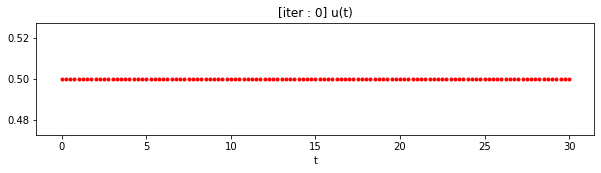

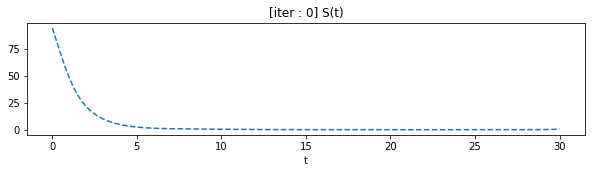

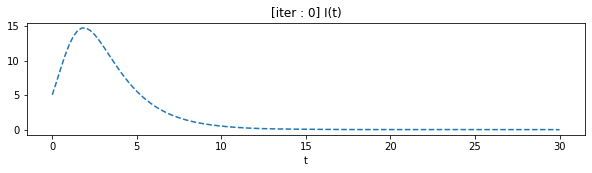

[iter : 999]:  33%|█████████████████████▌                                           | 998/3001 [00:28<00:54, 36.79it/s]

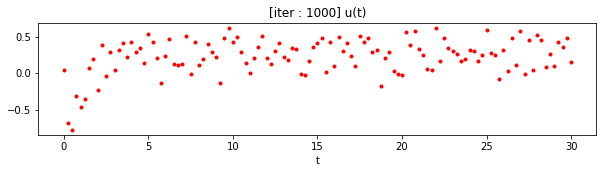

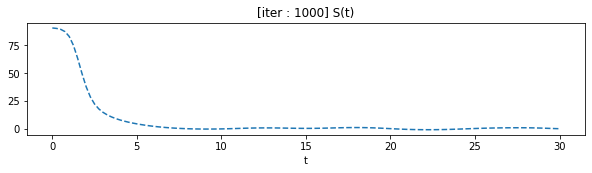

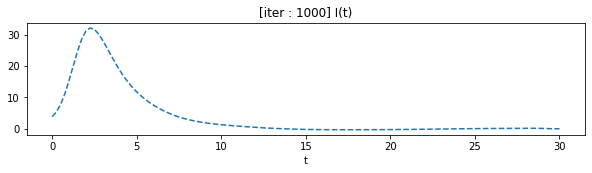

[iter : 1999]:  67%|█████████████████████████████████████████▉                     | 1997/3001 [00:57<00:28, 35.31it/s]

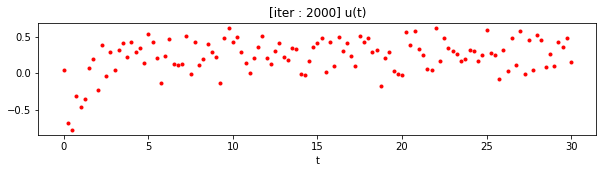

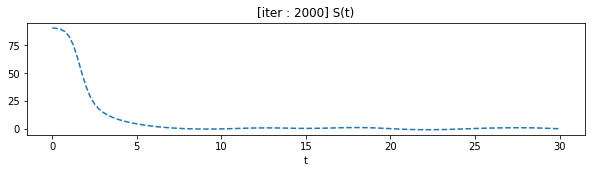

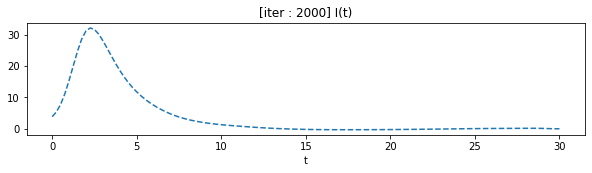

[iter : 2999]: 100%|██████████████████████████████████████████████████████████████▉| 2997/3001 [01:26<00:00, 35.57it/s]

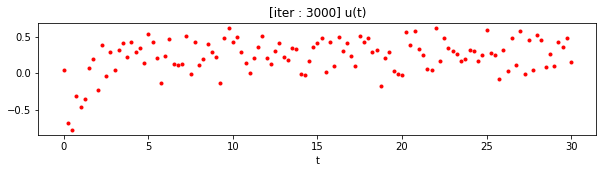

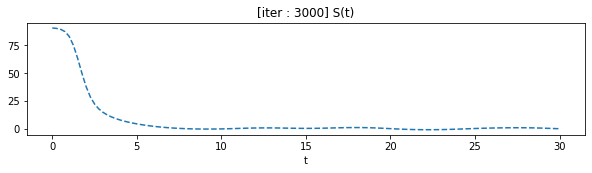

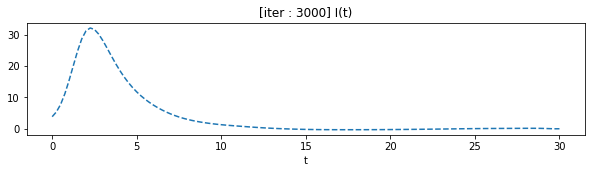

[iter : 3000]: 100%|███████████████████████████████████████████████████████████████| 3001/3001 [01:27<00:00, 34.47it/s]


In [135]:
model.eval()
pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
result = {}
losses = []
for iteration in pbar: 
    if iteration % 1000 == 0:
        viz(iteration,sensor_u)
        result[iteration] = sensor_u.detach().cpu().numpy()
        plt.show()
    
    if rec:
        lbfgs.step(closure_rec)
    else:
        lbfgs.step(closure)
    if clamp:
        sensor_u.data = torch.clamp(sensor_u.data,min=0,max=1)

    
    pbar.set_description("[iter : %d]"%(iteration))

cost functional value : tensor(38.9459, device='cuda:0', grad_fn=<DivBackward1>)


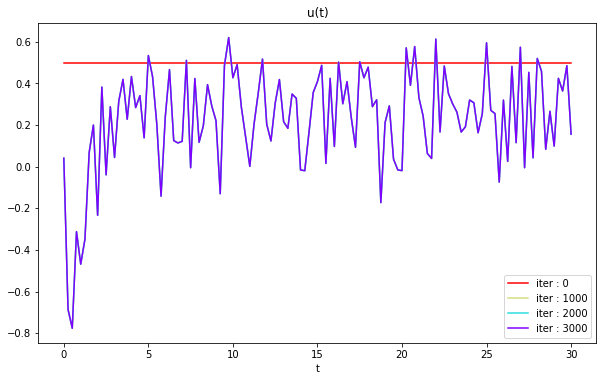

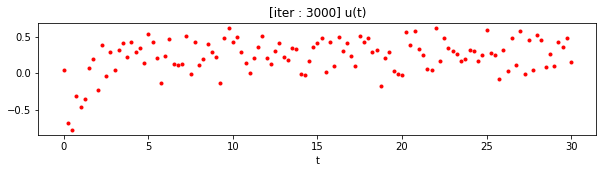

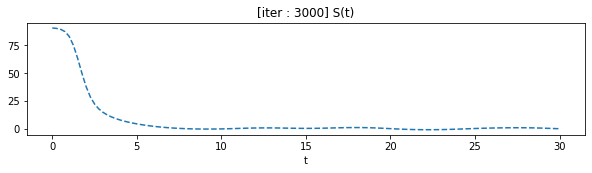

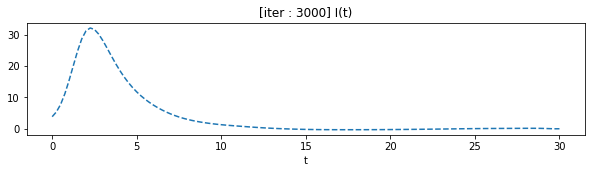

In [136]:
### final result ###
model.eval()
test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
pred=model(test_x[:,M:],test_x[:,:M])
sensor_s = pred[:,0]*load_data['S0']
sensor_i = pred[:,1]*load_data['I0']
print('cost functional value :',torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D*load_data['T']))

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)  

colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
for i,(k,v) in enumerate(result.items()):
    plt.plot(D, v,color=colors[i],label = 'iter : '+str(k))
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
#plt.title("u(t) {degree :%d}"%(degree))
plt.title("u(t)") 
plt.legend()

viz(num_iter,sensor_u)

18025


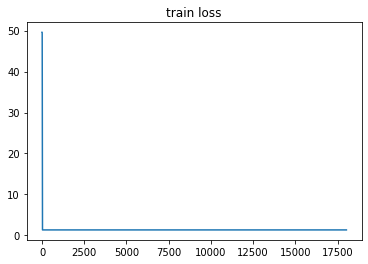

In [137]:
print(len(losses))

plt.title("train loss") 
plt.plot(losses)

In [138]:
min(losses)

1.3442188501358032

## example

In [7]:
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2


# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = f(x_lbfgs)
    objective.backward()
    return objective

x_lbfgs = 10*torch.ones(2, 1)
x_lbfgs.requires_grad = True

lbfgs = optim.LBFGS([x_lbfgs],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")
                    
history_lbfgs = []
for i in range(100):
    history_lbfgs.append(f(x_lbfgs).item())
    lbfgs.step(closure)

tensor([[10.],
        [10.]])


In [ ]:
def train_model(epoch, model, cost_function, optimizer, train_data, train_label):
  loss_graph = []
  net = net.to(device)
  
  for i in range(epoch): #훈련 횟수 설정
  
  	#학습 데이터와 라벨을 gpu에 보내는 코드
  	train_data = train_data.to(device)
    train_label = train_label.to(device)
    net.train()
    
      #LBGFS가 돌아가기 위한 closure
      def closure():
     
        optimizer.zero_grad()

        y_pred = model(train_data)
        loss = cost_function(y_pred, train_label)
        loss.backward()
        return loss

    optimizer.step(closure)
    loss = closure()
    loss_graph.append(loss.item())
  return loss_graph